## 데이터 준비

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

In [21]:
california = fetch_california_housing()

df = pd.DataFrame(california.data, columns=california.feature_names)
df['Target'] = california.target
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


In [22]:
scaler = StandardScaler()
scaler.fit(df.values[:,:-1])
df.values[:,:-1] = scaler.transform(df.values[:,:-1])
df.tail()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
20635,-1.216128,-0.289187,-0.155023,0.077354,-0.512592,-0.049110,1.801647,-0.758826,0.781
20636,-0.691593,-0.845393,0.276881,0.462365,-0.944405,0.005021,1.806329,-0.818722,0.771
20637,-1.142593,-0.924851,-0.090318,0.049414,-0.369537,-0.071735,1.778237,-0.823713,0.923
20638,-1.054583,-0.845393,-0.040211,0.158778,-0.604429,-0.091225,1.778237,-0.873626,0.847
20639,-0.780129,-1.004309,-0.070443,0.138403,-0.033977,-0.043682,1.750146,-0.833696,0.894


## 학습 코드 구현

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [24]:
data = torch.from_numpy(df.values).float()

x = data[:,:-1]
y = data[:,-1:]

print(x.shape,y.shape)

torch.Size([20640, 8]) torch.Size([20640, 1])


In [37]:
n_epochs = 4000
batch_size = 256
print_interval = 200

In [38]:
model = nn.Sequential(
    nn.Linear(x.size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6,5),
    nn.LeakyReLU(),
    nn.Linear(5,4),
    nn.LeakyReLU(),
    nn.Linear(4,3),
    nn.LeakyReLU(),
    nn.Linear(3, y.size(-1))
)

In [39]:
optimizer = optim.Adam(model.parameters()) #트랜스포머를 사용하느 수준에 다다르면 아담의 학습률을 튜닝해야한다.

In [40]:
for i in range(n_epochs):
    # Shuffle the index to feed-forward.
    indices = torch.randperm(x.size(0))
    x_ = torch.index_select(x, dim=0, index=indices)
    y_ = torch.index_select(y, dim=0, index=indices)

    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    y_hat = []
    total_loss = 0

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        total_loss += float(loss)
        y_hat += [y_hat_i]

    total_loss = total_loss / len(x_)
    if (i+1) % print_interval == 0:
        print('Epoch %d : loss=%.4e' % (i+1, total_loss))

y_hat = torch.cat(y_hat, dim=0)
y = torch.cat(y_, dim=0)

Epoch 200 : loss=3.3091e-01
Epoch 400 : loss=3.1996e-01
Epoch 600 : loss=3.1378e-01
Epoch 800 : loss=3.1330e-01
Epoch 1000 : loss=3.1251e-01
Epoch 1200 : loss=3.1153e-01
Epoch 1400 : loss=3.1118e-01
Epoch 1600 : loss=3.0999e-01
Epoch 1800 : loss=3.0862e-01
Epoch 2000 : loss=3.0895e-01
Epoch 2200 : loss=3.0806e-01
Epoch 2400 : loss=3.0810e-01
Epoch 2600 : loss=3.0634e-01
Epoch 2800 : loss=3.0675e-01
Epoch 3000 : loss=3.0679e-01
Epoch 3200 : loss=3.0616e-01
Epoch 3400 : loss=3.0615e-01
Epoch 3600 : loss=3.0617e-01
Epoch 3800 : loss=3.0679e-01
Epoch 4000 : loss=3.0579e-01


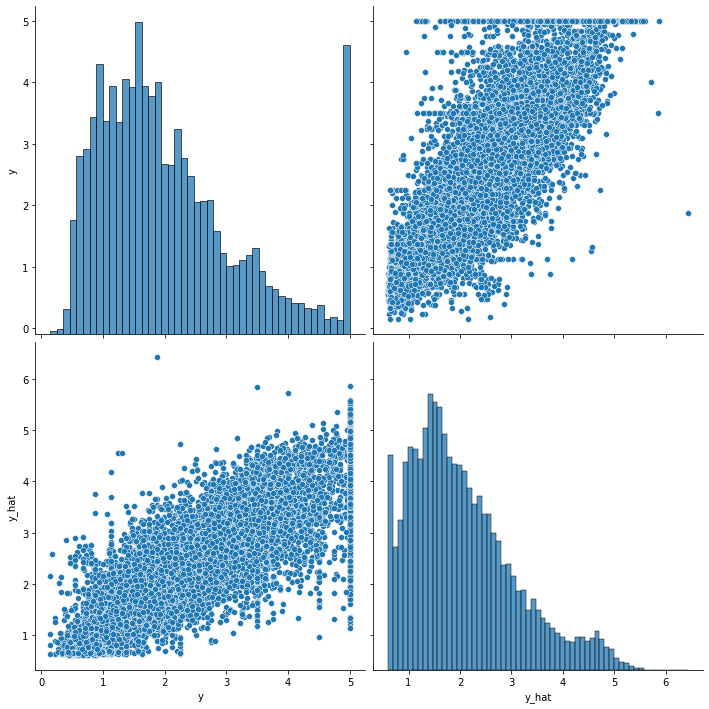

In [41]:
df =  pd.DataFrame(torch.cat([y,y_hat], dim=1).detach().numpy(), columns=['y','y_hat'])
sns.pairplot(df, height=5)
plt.show()